## Device Stuff

In [74]:
import torch

#Set up device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## Dataset

In [75]:
import os
import sys
from pathlib import Path
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [76]:
scriptpath = "../src/"
sys.path.append(os.path.abspath(scriptpath))
from utils import get_classes_indexes

In [77]:
source_folder = os.path.join('..', 'data', 'internal', 'preprocessed_videos')

def create_dataframe(videos_root):
    data = []
    
    classes_to_extract = os.listdir(videos_root)
    
    classes_data = get_classes_indexes(class_file_name="../data/raw/dataset/wlasl_class_list.txt", classes_to_extract=classes_to_extract)

    CLASS_TO_IDX = {class_name : idx for (idx, class_name) in  classes_data}
    IDX_TO_CLASS = {idx : class_name for (idx, class_name) in  classes_data}
    
    for class_name in os.listdir(videos_root):
        class_path = os.path.join(videos_root, class_name)
        for name in os.listdir(class_path):
            name = Path(name).stem
            data.append([name, CLASS_TO_IDX[class_name], class_name])
    return pd.DataFrame(data, columns=['video_name', 'class_id', 'class_name'])

dataset = create_dataframe(source_folder)

dataset.sample(20)

,video_name,class_id,class_name
122,31897,159,know
326,WIN_20231127_20_25_15_Pro,179,you
51,WIN_20231127_19_32_27_Pro,1636,blow
306,64379,179,you
165,WIN_20231127_19_44_00_Pro,1805,let
303,WIN_20231127_20_21_30_Pro,1999,whistle
213,WIN_20231127_20_11_47_Pro,1164,me
286,WIN_20231127_20_19_57_Pro,1999,whistle
105,WIN_20231127_00_26_45_Pro,1721,due
5,01734,632,airplane


In [78]:
import cv2

max_frame_count = 0

for key, row in dataset.iterrows():
    class_name = row['class_name']
    file_name = row['video_name']
    file_path = os.path.join(source_folder, class_name, file_name+'.mp4')
    cap = cv2.VideoCapture(file_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    max_frame_count = max(max_frame_count, length)
    
print('Maximum frame count:',max_frame_count)

Maximum frame count: 168


In [79]:
IDX_TO_CLASS = [ c_id for i, c_id in enumerate(set(dataset.class_id))]
CLASS_TO_IDX = { c_id: i for i, c_id in enumerate(IDX_TO_CLASS)}

In [80]:
from os.path import exists
import torch.nn.functional as F

class ASLDataset(Dataset):
    """
    A custom dataset class for loading American Sign Language (ASL) videos and their corresponding labels.

    Args:
        tensors_folder (str): Path to the folder containing the .pt arrays (converted videos).
        dataset_df (DataFrame): Pandas dataframe with information about videos
        max_frame_count (int): Maximum length of video in frames.
        ohe (OneHotEncoder): Required to encode class id to one hot numeric array.

    Attributes:
        tensors_folder (str): Path to the folder containing the .pt arrays (converted videos).
        name_with_label (dict): A dictionary mapping video names to their labels.
        classes (list): A list of class names.
    """

    def __init__(self, tensors_folder: str, dataset_df: pd.DataFrame, max_frame_count: int) -> None:
        # Default frame (set of points) to insert in short videos to make all videos equal in length
        default_frame = [0] * (21 * 3 * 2 + 33 * 3)
        
        self.tensor_sequences = []
        self.targets = []
        for i, row in dataset_df.iterrows():
            path_to_tensor = tensors_folder + '/' + row["video_name"] + '.pt'
            
            if not exists(path_to_tensor):
                continue
            
            # Open the video file using OpenCV
            tensor = torch.load(path_to_tensor)

            # Change length of video (not a video but sequence of frames with points coordinates in each frame)
            # pad_right = [default_frame for _ in range(0, max_frame_count - tensor.shape[0])]
            # pad_right = torch.tensor(pad_right)
            # self.tensor_sequences.append(torch.cat((pad_right, F.normalize(tensor.float(), dim=1))))
            self.tensor_sequences.append(F.normalize(tensor.float(), dim=1))
            self.targets.append(CLASS_TO_IDX[dataset_df["class_id"][i]])
        self.targets = torch.tensor(self.targets)
            
            
    def __len__(self):
        """
        Returns the number of videos in the dataset.

        Returns:
            int: The number of videos in the dataset.
        """
        return len(self.targets)

    def __getitem__(self, index):
        """
        Retrieves a video and its corresponding label from the dataset.

        Args:
            index (int): The index of the video to retrieve.

        Returns:
            tuple: A tuple containing the video frames as a PyTorch tensor and the label.
        """

        return self.tensor_sequences[index].float(), self.targets[index].long()


In [81]:
def read_classes(path):
    classes = dict()
    with open(path, 'r') as file:
        for line in file:
            line = line.strip().split('\t')
            key = int(line[0])
            value = line[1]
            classes[key] = value
    return classes

In [82]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [83]:
classes = read_classes('../data/raw/dataset/wlasl_class_list.txt')

train_dataset = ASLDataset('../data/internal/features', train, max_frame_count)
test_dataset = ASLDataset('../data/internal/features', test, max_frame_count)

In [84]:
# Create dataloaders
batch_size = 1

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}")
#print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 284
Test size: 71


## Model

In [85]:
import torch.nn as nn

class SequenceModel(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super().__init__()
        self.lstm = nn.Sequential(
            nn.LSTM(input_size, 64, 1, batch_first=True, bidirectional=True),
        )
        self.linear = nn.Sequential(
            nn.Linear(64 * 2, 16),
            nn.ReLU(),
            nn.Linear(16, output_size),
        )

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:,-1,:])

        return x

## Training

In [86]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm


def train_model(model: nn.Module, epochs: int, criterion, optimizer, ckpt_path='models/best.pt'):
    """
    Function that trains model using number of epochs, loss function, optimizer.
    Can use validation or test data set for evaluation.
    Calculates f1 score.

    Parameter
    ---------
    model : nn.Module
      Model to train.
    epochs: int
      Number of train epochs
    criterion
      The loss function from pytorch
    optimizer
      The optimizer from pytorch
    """

    model.train()
    model.to(device)

    history = {'train_losses': [], 'test_losses': [],
               'train_scores': [], 'test_scores': []}

    # Train the model
    for epoch in range(epochs):
        model.train()

        predicted_train = []
        true_train = []

        train_loss = 0.0

        bar = tqdm(train_dataloader)
        iterations = 0

        for inputs, targets in bar:
          
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            train_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

            # Get predicted classes and true classes from data
            predictions = torch.argmax(outputs, dim=1)
            for item in predictions:
                predicted_train.append(item.cpu().numpy())
            for item in targets:
                true_train.append(item.cpu().numpy())
            iterations += 1
            bar.set_postfix(
                ({"loss": f"{train_loss/(iterations*train_dataloader.batch_size)}"}))

        # Computing loss
        train_loss /= len(train_dataset)
        # Computing f1 score
        train_f1 = f1_score(true_train, predicted_train, average="macro")

        # Printing information in the end of train loop
        test_loss, test_f1 = test_model(model, criterion, test_dataloader)

        if not history['test_scores'] or test_f1 > max(history['test_scores']):
          torch.save(model.state_dict(), ckpt_path)

        history['train_losses'].append(train_loss)
        history['test_losses'].append(test_loss)
        history['train_scores'].append(train_f1)
        history['test_scores'].append(test_f1)

        print(f"Epoch {epoch+1} train (loss: {train_loss:.4f}, f1 score: {train_f1:.4f}) test (loss: {test_loss:.4f}, f1 score: {test_f1:.4f})")

    return history


def test_model(model: nn.Module, criterion, test_dataloader: DataLoader):
    """
    Function that evaluates model on specified dataloader
    by specified loss function.

    Parameter
    ---------
    model : nn.Module
      Model to train.
    criterion
      The loss function from pytorch
    test_dataloader: DataLoader
      The dataset for testing model

    Returns
    -------
    float: loss of model on given dataset
    float: f1 score of model on given dataset
    """

    model.eval()
    model.to(device)

    # Test loss value
    test_loss = 0.0

    # Lists for calculation f1 score
    predicted_test = []
    true_test = []

    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            test_loss += criterion(outputs, targets)

            # Get predicted classes and true classes from data
            predictions = torch.argmax(outputs, dim=1)
            for item in predictions:
                predicted_test.append(item.cpu().numpy())
            for item in targets:
                true_test.append(item.cpu().numpy())

    # Computation of test loss
    test_loss /= len(test_dataloader)

    # Computation of f1 score
    test_f1 = f1_score(true_test, predicted_test, average="macro")
    return test_loss.item(), test_f1

In [87]:
model = SequenceModel(input_size=225, output_size=len(IDX_TO_CLASS))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [88]:
history = train_model(model, 200, criterion, optimizer, ckpt_path='../models/simple_lstm/best.pt')

100%|██████████| 284/284 [00:03<00:00, 73.73it/s, loss=2.4702513981872882]


Epoch 1 train (loss: 2.4703, f1 score: 0.0304) test (loss: 2.4570, f1 score: 0.0110)


100%|██████████| 284/284 [00:03<00:00, 78.50it/s, loss=2.437996466394881] 


Epoch 2 train (loss: 2.4380, f1 score: 0.0346) test (loss: 2.4418, f1 score: 0.0110)


100%|██████████| 284/284 [00:03<00:00, 74.91it/s, loss=2.416597312185126] 


Epoch 3 train (loss: 2.4166, f1 score: 0.0377) test (loss: 2.4454, f1 score: 0.0110)


100%|██████████| 284/284 [00:03<00:00, 83.09it/s, loss=2.4106087646853758]


Epoch 4 train (loss: 2.4106, f1 score: 0.0462) test (loss: 2.4301, f1 score: 0.0337)


100%|██████████| 284/284 [00:03<00:00, 82.03it/s, loss=2.396026242366979] 


Epoch 5 train (loss: 2.3960, f1 score: 0.0423) test (loss: 2.4415, f1 score: 0.0362)


100%|██████████| 284/284 [00:03<00:00, 82.29it/s, loss=2.3815710615943857]


Epoch 6 train (loss: 2.3816, f1 score: 0.0438) test (loss: 2.4023, f1 score: 0.0308)


100%|██████████| 284/284 [00:03<00:00, 86.53it/s, loss=2.334929809394017] 


Epoch 7 train (loss: 2.3349, f1 score: 0.0602) test (loss: 2.3994, f1 score: 0.0393)


100%|██████████| 284/284 [00:03<00:00, 78.45it/s, loss=2.264632690330626] 


Epoch 8 train (loss: 2.2646, f1 score: 0.0722) test (loss: 2.3397, f1 score: 0.0738)


100%|██████████| 284/284 [00:03<00:00, 76.38it/s, loss=2.1319674713091112]


Epoch 9 train (loss: 2.1320, f1 score: 0.0928) test (loss: 2.2343, f1 score: 0.0738)


100%|██████████| 284/284 [00:04<00:00, 66.97it/s, loss=2.0815554013947994]


Epoch 10 train (loss: 2.0816, f1 score: 0.1280) test (loss: 2.3012, f1 score: 0.0603)


100%|██████████| 284/284 [00:03<00:00, 81.56it/s, loss=2.038689220088049] 


Epoch 11 train (loss: 2.0387, f1 score: 0.1236) test (loss: 2.0548, f1 score: 0.0730)


100%|██████████| 284/284 [00:03<00:00, 71.33it/s, loss=1.8438983639623499]


Epoch 12 train (loss: 1.8439, f1 score: 0.1547) test (loss: 1.8872, f1 score: 0.1354)


100%|██████████| 284/284 [00:03<00:00, 87.34it/s, loss=1.8124495088581887]


Epoch 13 train (loss: 1.8124, f1 score: 0.1762) test (loss: 1.8644, f1 score: 0.0761)


100%|██████████| 284/284 [00:03<00:00, 85.11it/s, loss=1.7523545374254315]


Epoch 14 train (loss: 1.7524, f1 score: 0.2218) test (loss: 1.8359, f1 score: 0.1298)


100%|██████████| 284/284 [00:02<00:00, 122.59it/s, loss=1.718824100615063] 


Epoch 15 train (loss: 1.7188, f1 score: 0.2005) test (loss: 1.8368, f1 score: 0.1990)


100%|██████████| 284/284 [00:01<00:00, 218.91it/s, loss=1.74088075472383]  


Epoch 16 train (loss: 1.7409, f1 score: 0.2600) test (loss: 1.9482, f1 score: 0.1617)


100%|██████████| 284/284 [00:01<00:00, 226.14it/s, loss=1.675205755165555] 


Epoch 17 train (loss: 1.6752, f1 score: 0.2295) test (loss: 1.7848, f1 score: 0.1351)


100%|██████████| 284/284 [00:01<00:00, 198.89it/s, loss=1.658587110438712] 


Epoch 18 train (loss: 1.6586, f1 score: 0.2475) test (loss: 1.7933, f1 score: 0.1649)


100%|██████████| 284/284 [00:01<00:00, 187.58it/s, loss=1.5806411947451637]


Epoch 19 train (loss: 1.5806, f1 score: 0.2564) test (loss: 1.6724, f1 score: 0.1825)


100%|██████████| 284/284 [00:01<00:00, 192.64it/s, loss=1.5298107651777197]


Epoch 20 train (loss: 1.5298, f1 score: 0.2975) test (loss: 1.6742, f1 score: 0.2589)


100%|██████████| 284/284 [00:01<00:00, 200.79it/s, loss=1.6118219510560305]


Epoch 21 train (loss: 1.6118, f1 score: 0.2777) test (loss: 1.7294, f1 score: 0.2070)


100%|██████████| 284/284 [00:01<00:00, 200.36it/s, loss=1.5935289858197663]


Epoch 22 train (loss: 1.5935, f1 score: 0.3208) test (loss: 1.6416, f1 score: 0.2727)


100%|██████████| 284/284 [00:01<00:00, 198.65it/s, loss=1.5170853735196967]


Epoch 23 train (loss: 1.5171, f1 score: 0.3594) test (loss: 1.7024, f1 score: 0.2935)


100%|██████████| 284/284 [00:01<00:00, 214.89it/s, loss=1.4735077633456866]


Epoch 24 train (loss: 1.4735, f1 score: 0.3209) test (loss: 1.5928, f1 score: 0.3464)


100%|██████████| 284/284 [00:01<00:00, 215.43it/s, loss=1.4242377167265914]


Epoch 25 train (loss: 1.4242, f1 score: 0.3865) test (loss: 1.5882, f1 score: 0.3219)


100%|██████████| 284/284 [00:01<00:00, 211.99it/s, loss=1.4130699157478734]


Epoch 26 train (loss: 1.4131, f1 score: 0.4371) test (loss: 1.5690, f1 score: 0.3494)


100%|██████████| 284/284 [00:01<00:00, 215.20it/s, loss=1.470318614780693] 


Epoch 27 train (loss: 1.4703, f1 score: 0.3652) test (loss: 1.6292, f1 score: 0.3348)


100%|██████████| 284/284 [00:01<00:00, 209.52it/s, loss=1.3872290055306864]


Epoch 28 train (loss: 1.3872, f1 score: 0.4150) test (loss: 1.5324, f1 score: 0.3301)


100%|██████████| 284/284 [00:01<00:00, 218.13it/s, loss=1.3898696106609325]


Epoch 29 train (loss: 1.3899, f1 score: 0.4233) test (loss: 1.6101, f1 score: 0.2762)


100%|██████████| 284/284 [00:01<00:00, 214.70it/s, loss=1.3607835310452263]


Epoch 30 train (loss: 1.3608, f1 score: 0.4050) test (loss: 1.6020, f1 score: 0.4236)


100%|██████████| 284/284 [00:01<00:00, 210.42it/s, loss=1.289231485457645] 


Epoch 31 train (loss: 1.2892, f1 score: 0.4907) test (loss: 1.4999, f1 score: 0.3460)


100%|██████████| 284/284 [00:01<00:00, 207.08it/s, loss=1.3476805668717748]


Epoch 32 train (loss: 1.3477, f1 score: 0.5012) test (loss: 1.5946, f1 score: 0.3612)


100%|██████████| 284/284 [00:01<00:00, 209.39it/s, loss=1.3659274490348483]


Epoch 33 train (loss: 1.3659, f1 score: 0.4826) test (loss: 1.5100, f1 score: 0.3745)


100%|██████████| 284/284 [00:01<00:00, 221.70it/s, loss=1.2669856584742403]


Epoch 34 train (loss: 1.2670, f1 score: 0.4613) test (loss: 1.5795, f1 score: 0.3359)


100%|██████████| 284/284 [00:01<00:00, 224.07it/s, loss=1.2276671519880118]


Epoch 35 train (loss: 1.2277, f1 score: 0.4688) test (loss: 1.4745, f1 score: 0.4084)


100%|██████████| 284/284 [00:01<00:00, 198.35it/s, loss=1.232374215846173] 


Epoch 36 train (loss: 1.2324, f1 score: 0.5188) test (loss: 1.5155, f1 score: 0.4190)


100%|██████████| 284/284 [00:01<00:00, 216.47it/s, loss=1.1870474702035878]


Epoch 37 train (loss: 1.1870, f1 score: 0.5019) test (loss: 1.4068, f1 score: 0.4190)


100%|██████████| 284/284 [00:01<00:00, 215.07it/s, loss=1.1492385758139507]


Epoch 38 train (loss: 1.1492, f1 score: 0.5644) test (loss: 1.4762, f1 score: 0.4494)


100%|██████████| 284/284 [00:01<00:00, 210.29it/s, loss=1.1665135543911496]


Epoch 39 train (loss: 1.1665, f1 score: 0.5400) test (loss: 1.5612, f1 score: 0.3623)


100%|██████████| 284/284 [00:01<00:00, 224.11it/s, loss=1.1716784462103174]


Epoch 40 train (loss: 1.1717, f1 score: 0.5387) test (loss: 1.5160, f1 score: 0.4864)


100%|██████████| 284/284 [00:01<00:00, 221.45it/s, loss=1.1195587540655332]


Epoch 41 train (loss: 1.1196, f1 score: 0.5686) test (loss: 1.6342, f1 score: 0.3543)


100%|██████████| 284/284 [00:01<00:00, 222.14it/s, loss=1.1984307289280942]


Epoch 42 train (loss: 1.1984, f1 score: 0.5305) test (loss: 1.5070, f1 score: 0.4362)


100%|██████████| 284/284 [00:01<00:00, 229.04it/s, loss=1.1575230417041842]


Epoch 43 train (loss: 1.1575, f1 score: 0.5323) test (loss: 1.5240, f1 score: 0.4451)


100%|██████████| 284/284 [00:01<00:00, 212.95it/s, loss=1.0439296907312434]


Epoch 44 train (loss: 1.0439, f1 score: 0.6077) test (loss: 1.4865, f1 score: 0.4419)


100%|██████████| 284/284 [00:01<00:00, 212.93it/s, loss=1.071018224809168] 


Epoch 45 train (loss: 1.0710, f1 score: 0.5740) test (loss: 2.0444, f1 score: 0.4040)


100%|██████████| 284/284 [00:01<00:00, 229.03it/s, loss=1.117874916078864] 


Epoch 46 train (loss: 1.1179, f1 score: 0.5501) test (loss: 1.6284, f1 score: 0.4384)


100%|██████████| 284/284 [00:01<00:00, 215.47it/s, loss=0.9878104754123496]


Epoch 47 train (loss: 0.9878, f1 score: 0.6429) test (loss: 1.7078, f1 score: 0.4109)


100%|██████████| 284/284 [00:01<00:00, 201.09it/s, loss=1.1082969410033425]


Epoch 48 train (loss: 1.1083, f1 score: 0.5851) test (loss: 1.4344, f1 score: 0.4224)


100%|██████████| 284/284 [00:01<00:00, 198.93it/s, loss=1.0376168458237194]


Epoch 49 train (loss: 1.0376, f1 score: 0.5744) test (loss: 1.4435, f1 score: 0.4412)


100%|██████████| 284/284 [00:01<00:00, 203.08it/s, loss=0.9904821472763884]


Epoch 50 train (loss: 0.9905, f1 score: 0.5885) test (loss: 1.4817, f1 score: 0.4426)


100%|██████████| 284/284 [00:01<00:00, 203.43it/s, loss=1.0807896856592418]


Epoch 51 train (loss: 1.0808, f1 score: 0.5516) test (loss: 1.4114, f1 score: 0.5226)


100%|██████████| 284/284 [00:01<00:00, 210.53it/s, loss=1.034027464033603] 


Epoch 52 train (loss: 1.0340, f1 score: 0.5833) test (loss: 1.4218, f1 score: 0.4798)


100%|██████████| 284/284 [00:01<00:00, 205.44it/s, loss=1.0073233223930131]


Epoch 53 train (loss: 1.0073, f1 score: 0.6174) test (loss: 1.5560, f1 score: 0.4071)


100%|██████████| 284/284 [00:01<00:00, 203.18it/s, loss=0.971960581275864] 


Epoch 54 train (loss: 0.9720, f1 score: 0.6036) test (loss: 1.6686, f1 score: 0.4563)


100%|██████████| 284/284 [00:01<00:00, 203.32it/s, loss=0.8529936027447497]


Epoch 55 train (loss: 0.8530, f1 score: 0.6954) test (loss: 1.5102, f1 score: 0.4312)


100%|██████████| 284/284 [00:01<00:00, 210.26it/s, loss=0.8159576757961858]


Epoch 56 train (loss: 0.8160, f1 score: 0.6897) test (loss: 1.4631, f1 score: 0.4776)


100%|██████████| 284/284 [00:01<00:00, 220.55it/s, loss=0.8325879373161358]


Epoch 57 train (loss: 0.8326, f1 score: 0.6609) test (loss: 1.5994, f1 score: 0.4120)


100%|██████████| 284/284 [00:01<00:00, 192.36it/s, loss=0.7779062484459899]


Epoch 58 train (loss: 0.7779, f1 score: 0.6700) test (loss: 1.5574, f1 score: 0.4761)


100%|██████████| 284/284 [00:01<00:00, 212.09it/s, loss=0.7646132932412668]


Epoch 59 train (loss: 0.7646, f1 score: 0.7192) test (loss: 1.4048, f1 score: 0.5171)


100%|██████████| 284/284 [00:01<00:00, 212.02it/s, loss=0.8071372897821663]


Epoch 60 train (loss: 0.8071, f1 score: 0.6903) test (loss: 1.4930, f1 score: 0.5110)


100%|██████████| 284/284 [00:01<00:00, 215.99it/s, loss=0.7844165055885498]


Epoch 61 train (loss: 0.7844, f1 score: 0.7029) test (loss: 1.4454, f1 score: 0.4685)


100%|██████████| 284/284 [00:01<00:00, 210.27it/s, loss=0.783110821939567] 


Epoch 62 train (loss: 0.7831, f1 score: 0.7100) test (loss: 1.5221, f1 score: 0.4409)


100%|██████████| 284/284 [00:01<00:00, 218.27it/s, loss=0.7132222089087623]


Epoch 63 train (loss: 0.7132, f1 score: 0.7375) test (loss: 1.4700, f1 score: 0.4091)


100%|██████████| 284/284 [00:01<00:00, 189.48it/s, loss=0.7292240796781647]


Epoch 64 train (loss: 0.7292, f1 score: 0.7384) test (loss: 1.3509, f1 score: 0.5533)


100%|██████████| 284/284 [00:01<00:00, 214.94it/s, loss=0.7942501985245387]


Epoch 65 train (loss: 0.7943, f1 score: 0.6934) test (loss: 1.4986, f1 score: 0.4814)


100%|██████████| 284/284 [00:01<00:00, 207.87it/s, loss=0.7239271225682874]


Epoch 66 train (loss: 0.7239, f1 score: 0.7530) test (loss: 1.5178, f1 score: 0.4874)


100%|██████████| 284/284 [00:01<00:00, 202.65it/s, loss=0.7596128433233645]


Epoch 67 train (loss: 0.7596, f1 score: 0.7231) test (loss: 1.4464, f1 score: 0.4880)


100%|██████████| 284/284 [00:01<00:00, 214.84it/s, loss=0.9107202865504828]


Epoch 68 train (loss: 0.9107, f1 score: 0.6648) test (loss: 1.5323, f1 score: 0.5046)


100%|██████████| 284/284 [00:01<00:00, 213.09it/s, loss=0.6592674057395361]


Epoch 69 train (loss: 0.6593, f1 score: 0.7539) test (loss: 1.2432, f1 score: 0.5579)


100%|██████████| 284/284 [00:01<00:00, 218.46it/s, loss=0.6592793587462412]


Epoch 70 train (loss: 0.6593, f1 score: 0.7637) test (loss: 1.6882, f1 score: 0.3791)


100%|██████████| 284/284 [00:01<00:00, 221.76it/s, loss=0.6190714667751872]


Epoch 71 train (loss: 0.6191, f1 score: 0.7760) test (loss: 1.4933, f1 score: 0.5506)


100%|██████████| 284/284 [00:01<00:00, 211.97it/s, loss=0.5181949504090163] 


Epoch 72 train (loss: 0.5182, f1 score: 0.8121) test (loss: 1.5109, f1 score: 0.5318)


100%|██████████| 284/284 [00:01<00:00, 218.24it/s, loss=0.6381139220824813]


Epoch 73 train (loss: 0.6381, f1 score: 0.7623) test (loss: 1.5448, f1 score: 0.5882)


100%|██████████| 284/284 [00:01<00:00, 223.92it/s, loss=0.52075647641712]  


Epoch 74 train (loss: 0.5208, f1 score: 0.8143) test (loss: 1.4934, f1 score: 0.5188)


100%|██████████| 284/284 [00:01<00:00, 226.79it/s, loss=0.5195563496174503] 


Epoch 75 train (loss: 0.5196, f1 score: 0.8309) test (loss: 1.7877, f1 score: 0.4439)


100%|██████████| 284/284 [00:01<00:00, 226.98it/s, loss=0.6163137845003445]


Epoch 76 train (loss: 0.6163, f1 score: 0.8042) test (loss: 1.4085, f1 score: 0.5244)


100%|██████████| 284/284 [00:01<00:00, 224.90it/s, loss=0.6175703663939716]


Epoch 77 train (loss: 0.6176, f1 score: 0.7453) test (loss: 1.4378, f1 score: 0.5105)


100%|██████████| 284/284 [00:01<00:00, 228.84it/s, loss=0.4726273231681774] 


Epoch 78 train (loss: 0.4726, f1 score: 0.8272) test (loss: 1.7314, f1 score: 0.4822)


100%|██████████| 284/284 [00:01<00:00, 226.73it/s, loss=0.4108711991037536] 


Epoch 79 train (loss: 0.4109, f1 score: 0.8766) test (loss: 1.5975, f1 score: 0.5846)


100%|██████████| 284/284 [00:01<00:00, 230.71it/s, loss=0.40711958708274787]


Epoch 80 train (loss: 0.4071, f1 score: 0.8631) test (loss: 1.4095, f1 score: 0.5428)


100%|██████████| 284/284 [00:01<00:00, 218.75it/s, loss=0.41716347893324524]


Epoch 81 train (loss: 0.4172, f1 score: 0.8500) test (loss: 1.4267, f1 score: 0.4824)


100%|██████████| 284/284 [00:01<00:00, 221.19it/s, loss=0.38242949697051304]


Epoch 82 train (loss: 0.3824, f1 score: 0.8963) test (loss: 1.7769, f1 score: 0.4850)


100%|██████████| 284/284 [00:01<00:00, 193.42it/s, loss=0.44970595048612205]


Epoch 83 train (loss: 0.4497, f1 score: 0.8612) test (loss: 1.4480, f1 score: 0.4460)


100%|██████████| 284/284 [00:01<00:00, 187.16it/s, loss=0.49259740317682654]


Epoch 84 train (loss: 0.4926, f1 score: 0.8444) test (loss: 1.4347, f1 score: 0.4844)


100%|██████████| 284/284 [00:01<00:00, 191.52it/s, loss=0.951964834460482] 


Epoch 85 train (loss: 0.9520, f1 score: 0.7262) test (loss: 1.2794, f1 score: 0.5101)


100%|██████████| 284/284 [00:01<00:00, 210.04it/s, loss=0.43855003320051866]


Epoch 86 train (loss: 0.4386, f1 score: 0.8560) test (loss: 1.3932, f1 score: 0.4242)


100%|██████████| 284/284 [00:01<00:00, 215.99it/s, loss=0.32923752916447896]


Epoch 87 train (loss: 0.3292, f1 score: 0.8880) test (loss: 1.3685, f1 score: 0.5260)


100%|██████████| 284/284 [00:01<00:00, 200.82it/s, loss=0.3223764430606832] 


Epoch 88 train (loss: 0.3224, f1 score: 0.8883) test (loss: 1.6489, f1 score: 0.4671)


100%|██████████| 284/284 [00:01<00:00, 198.07it/s, loss=0.46176334468037555]


Epoch 89 train (loss: 0.4618, f1 score: 0.8666) test (loss: 1.3427, f1 score: 0.4595)


100%|██████████| 284/284 [00:01<00:00, 221.23it/s, loss=0.31772778040296645]


Epoch 90 train (loss: 0.3177, f1 score: 0.8943) test (loss: 1.4826, f1 score: 0.4584)


100%|██████████| 284/284 [00:01<00:00, 208.20it/s, loss=0.4838095821421928] 


Epoch 91 train (loss: 0.4838, f1 score: 0.8349) test (loss: 1.3958, f1 score: 0.5743)


100%|██████████| 284/284 [00:01<00:00, 221.32it/s, loss=0.3913494218279186] 


Epoch 92 train (loss: 0.3913, f1 score: 0.8419) test (loss: 1.4353, f1 score: 0.5655)


100%|██████████| 284/284 [00:01<00:00, 221.98it/s, loss=0.3099436279736681] 


Epoch 93 train (loss: 0.3099, f1 score: 0.8937) test (loss: 1.3135, f1 score: 0.5856)


100%|██████████| 284/284 [00:01<00:00, 227.31it/s, loss=0.3063830746440813] 


Epoch 94 train (loss: 0.3064, f1 score: 0.9084) test (loss: 1.4236, f1 score: 0.5527)


100%|██████████| 284/284 [00:01<00:00, 221.06it/s, loss=0.23919698632488062]


Epoch 95 train (loss: 0.2392, f1 score: 0.9366) test (loss: 1.4812, f1 score: 0.5867)


100%|██████████| 284/284 [00:01<00:00, 227.16it/s, loss=0.22221746521552657]


Epoch 96 train (loss: 0.2222, f1 score: 0.9445) test (loss: 1.3566, f1 score: 0.5942)


100%|██████████| 284/284 [00:01<00:00, 227.51it/s, loss=0.29950852921647825]


Epoch 97 train (loss: 0.2995, f1 score: 0.9151) test (loss: 1.3981, f1 score: 0.5845)


100%|██████████| 284/284 [00:01<00:00, 218.16it/s, loss=0.2682270410664707] 


Epoch 98 train (loss: 0.2682, f1 score: 0.9226) test (loss: 1.3832, f1 score: 0.5221)


100%|██████████| 284/284 [00:01<00:00, 221.85it/s, loss=0.2261501259189521] 


Epoch 99 train (loss: 0.2262, f1 score: 0.9304) test (loss: 1.4656, f1 score: 0.5218)


100%|██████████| 284/284 [00:01<00:00, 223.21it/s, loss=0.29078739532845976]


Epoch 100 train (loss: 0.2908, f1 score: 0.9000) test (loss: 1.2601, f1 score: 0.5723)


100%|██████████| 284/284 [00:01<00:00, 205.84it/s, loss=0.21856883135865565]


Epoch 101 train (loss: 0.2186, f1 score: 0.9350) test (loss: 1.5173, f1 score: 0.5359)


100%|██████████| 284/284 [00:01<00:00, 198.83it/s, loss=0.1608489433665198] 


Epoch 102 train (loss: 0.1608, f1 score: 0.9569) test (loss: 1.4772, f1 score: 0.6051)


100%|██████████| 284/284 [00:01<00:00, 212.81it/s, loss=0.26568715605993365]


Epoch 103 train (loss: 0.2657, f1 score: 0.9230) test (loss: 1.8302, f1 score: 0.5099)


100%|██████████| 284/284 [00:01<00:00, 169.19it/s, loss=0.6352098596132788]


Epoch 104 train (loss: 0.6352, f1 score: 0.7866) test (loss: 2.0977, f1 score: 0.3587)


100%|██████████| 284/284 [00:01<00:00, 200.07it/s, loss=0.4606153477662945] 


Epoch 105 train (loss: 0.4606, f1 score: 0.8262) test (loss: 1.3617, f1 score: 0.5673)


100%|██████████| 284/284 [00:01<00:00, 197.25it/s, loss=0.19515798279867405]


Epoch 106 train (loss: 0.1952, f1 score: 0.9504) test (loss: 1.3910, f1 score: 0.5331)


100%|██████████| 284/284 [00:01<00:00, 201.46it/s, loss=0.14762182126881745]


Epoch 107 train (loss: 0.1476, f1 score: 0.9786) test (loss: 1.4723, f1 score: 0.5576)


100%|██████████| 284/284 [00:01<00:00, 215.47it/s, loss=0.15207849528621703]


Epoch 108 train (loss: 0.1521, f1 score: 0.9572) test (loss: 1.4537, f1 score: 0.5667)


100%|██████████| 284/284 [00:01<00:00, 202.24it/s, loss=0.21567831052498407]


Epoch 109 train (loss: 0.2157, f1 score: 0.9339) test (loss: 1.4525, f1 score: 0.5874)


100%|██████████| 284/284 [00:01<00:00, 224.17it/s, loss=0.16707660437747351]


Epoch 110 train (loss: 0.1671, f1 score: 0.9520) test (loss: 1.7942, f1 score: 0.5227)


100%|██████████| 284/284 [00:01<00:00, 207.27it/s, loss=0.24851500602480275]


Epoch 111 train (loss: 0.2485, f1 score: 0.9423) test (loss: 1.7247, f1 score: 0.4733)


100%|██████████| 284/284 [00:01<00:00, 223.51it/s, loss=0.4134245566093632] 


Epoch 112 train (loss: 0.4134, f1 score: 0.8640) test (loss: 1.5825, f1 score: 0.5261)


100%|██████████| 284/284 [00:01<00:00, 223.41it/s, loss=0.8005895015094083] 


Epoch 113 train (loss: 0.8006, f1 score: 0.7673) test (loss: 2.1654, f1 score: 0.4940)


100%|██████████| 284/284 [00:01<00:00, 221.18it/s, loss=0.3373759636357059] 


Epoch 114 train (loss: 0.3374, f1 score: 0.8854) test (loss: 1.5425, f1 score: 0.5340)


100%|██████████| 284/284 [00:01<00:00, 200.39it/s, loss=0.23301386348908687]


Epoch 115 train (loss: 0.2330, f1 score: 0.9273) test (loss: 1.7560, f1 score: 0.4789)


100%|██████████| 284/284 [00:01<00:00, 215.74it/s, loss=0.19537184685322898]


Epoch 116 train (loss: 0.1954, f1 score: 0.9379) test (loss: 1.7700, f1 score: 0.4596)


100%|██████████| 284/284 [00:01<00:00, 215.25it/s, loss=0.12213762213471288]


Epoch 117 train (loss: 0.1221, f1 score: 0.9707) test (loss: 1.6098, f1 score: 0.5531)


100%|██████████| 284/284 [00:01<00:00, 189.55it/s, loss=0.0944360673777955]  


Epoch 118 train (loss: 0.0944, f1 score: 0.9777) test (loss: 1.6814, f1 score: 0.5169)


100%|██████████| 284/284 [00:01<00:00, 184.40it/s, loss=0.3454699355853307] 


Epoch 119 train (loss: 0.3455, f1 score: 0.9045) test (loss: 1.5975, f1 score: 0.4843)


100%|██████████| 284/284 [00:01<00:00, 204.89it/s, loss=0.20478854825492676]


Epoch 120 train (loss: 0.2048, f1 score: 0.9371) test (loss: 1.4306, f1 score: 0.5369)


100%|██████████| 284/284 [00:01<00:00, 194.24it/s, loss=0.11918123648449733] 


Epoch 121 train (loss: 0.1192, f1 score: 0.9715) test (loss: 1.5861, f1 score: 0.5010)


100%|██████████| 284/284 [00:01<00:00, 196.51it/s, loss=0.36574478698263674]


Epoch 122 train (loss: 0.3657, f1 score: 0.9078) test (loss: 1.6253, f1 score: 0.5621)


100%|██████████| 284/284 [00:01<00:00, 200.00it/s, loss=0.16109544210974835]


Epoch 123 train (loss: 0.1611, f1 score: 0.9553) test (loss: 1.7034, f1 score: 0.4633)


100%|██████████| 284/284 [00:01<00:00, 196.30it/s, loss=0.11877495634443666] 


Epoch 124 train (loss: 0.1188, f1 score: 0.9548) test (loss: 1.5951, f1 score: 0.6202)


100%|██████████| 284/284 [00:01<00:00, 200.49it/s, loss=0.09195606458556332] 


Epoch 125 train (loss: 0.0920, f1 score: 0.9756) test (loss: 1.7690, f1 score: 0.5282)


100%|██████████| 284/284 [00:01<00:00, 215.60it/s, loss=0.519477540561011] 


Epoch 126 train (loss: 0.5195, f1 score: 0.8347) test (loss: 1.6082, f1 score: 0.4776)


100%|██████████| 284/284 [00:01<00:00, 204.77it/s, loss=0.20121235603236892]


Epoch 127 train (loss: 0.2012, f1 score: 0.9457) test (loss: 1.8331, f1 score: 0.4574)


100%|██████████| 284/284 [00:01<00:00, 202.97it/s, loss=0.14494171364713007]


Epoch 128 train (loss: 0.1449, f1 score: 0.9508) test (loss: 1.6168, f1 score: 0.5270)


100%|██████████| 284/284 [00:01<00:00, 199.38it/s, loss=0.11502593950650218]


Epoch 129 train (loss: 0.1150, f1 score: 0.9565) test (loss: 1.4576, f1 score: 0.5392)


100%|██████████| 284/284 [00:01<00:00, 202.77it/s, loss=0.06873693883126084] 


Epoch 130 train (loss: 0.0687, f1 score: 0.9864) test (loss: 1.5765, f1 score: 0.5204)


100%|██████████| 284/284 [00:01<00:00, 209.90it/s, loss=0.049685016910954394]


Epoch 131 train (loss: 0.0497, f1 score: 0.9916) test (loss: 1.6277, f1 score: 0.5698)


100%|██████████| 284/284 [00:01<00:00, 202.36it/s, loss=0.08335315656583915] 


Epoch 132 train (loss: 0.0834, f1 score: 0.9754) test (loss: 1.8127, f1 score: 0.5210)


100%|██████████| 284/284 [00:01<00:00, 205.30it/s, loss=0.19669941323259146]


Epoch 133 train (loss: 0.1967, f1 score: 0.9444) test (loss: 1.8909, f1 score: 0.4883)


100%|██████████| 284/284 [00:01<00:00, 199.49it/s, loss=0.20383122498558381]


Epoch 134 train (loss: 0.2038, f1 score: 0.9301) test (loss: 1.5005, f1 score: 0.6386)


100%|██████████| 284/284 [00:01<00:00, 203.15it/s, loss=0.30461049172625493]


Epoch 135 train (loss: 0.3046, f1 score: 0.9047) test (loss: 1.5216, f1 score: 0.5522)


100%|██████████| 284/284 [00:01<00:00, 200.03it/s, loss=0.13134095301455972]


Epoch 136 train (loss: 0.1313, f1 score: 0.9486) test (loss: 1.4432, f1 score: 0.5335)


100%|██████████| 284/284 [00:01<00:00, 185.03it/s, loss=0.07824170170735516] 


Epoch 137 train (loss: 0.0782, f1 score: 0.9764) test (loss: 1.2743, f1 score: 0.5477)


100%|██████████| 284/284 [00:01<00:00, 156.10it/s, loss=0.052459891109926604]


Epoch 138 train (loss: 0.0525, f1 score: 0.9877) test (loss: 1.4734, f1 score: 0.6366)


100%|██████████| 284/284 [00:01<00:00, 152.05it/s, loss=0.05040266758177716] 


Epoch 139 train (loss: 0.0504, f1 score: 0.9908) test (loss: 1.5829, f1 score: 0.5202)


100%|██████████| 284/284 [00:01<00:00, 150.82it/s, loss=0.5447946491048047] 


Epoch 140 train (loss: 0.5448, f1 score: 0.8244) test (loss: 1.9045, f1 score: 0.4244)


100%|██████████| 284/284 [00:01<00:00, 223.89it/s, loss=0.4304238365742856] 


Epoch 141 train (loss: 0.4304, f1 score: 0.8635) test (loss: 1.3924, f1 score: 0.5270)


100%|██████████| 284/284 [00:01<00:00, 216.15it/s, loss=0.101997763251421]  


Epoch 142 train (loss: 0.1020, f1 score: 0.9860) test (loss: 1.3916, f1 score: 0.4933)


100%|██████████| 284/284 [00:01<00:00, 213.36it/s, loss=0.06454549601603207] 


Epoch 143 train (loss: 0.0645, f1 score: 0.9833) test (loss: 1.4441, f1 score: 0.5396)


100%|██████████| 284/284 [00:01<00:00, 223.49it/s, loss=0.1397534632031552] 


Epoch 144 train (loss: 0.1398, f1 score: 0.9604) test (loss: 1.5298, f1 score: 0.5140)


100%|██████████| 284/284 [00:01<00:00, 210.76it/s, loss=0.1832281007391934] 


Epoch 145 train (loss: 0.1832, f1 score: 0.9557) test (loss: 1.5303, f1 score: 0.5236)


100%|██████████| 284/284 [00:01<00:00, 217.95it/s, loss=0.04688963288488804] 


Epoch 146 train (loss: 0.0469, f1 score: 0.9877) test (loss: 1.6247, f1 score: 0.5317)


100%|██████████| 284/284 [00:01<00:00, 213.03it/s, loss=0.030197535277458953]


Epoch 147 train (loss: 0.0302, f1 score: 0.9969) test (loss: 1.5755, f1 score: 0.5777)


100%|██████████| 284/284 [00:01<00:00, 218.13it/s, loss=0.021337472008143645]


Epoch 148 train (loss: 0.0213, f1 score: 1.0000) test (loss: 1.5078, f1 score: 0.5729)


100%|██████████| 284/284 [00:01<00:00, 213.04it/s, loss=0.026516163348345875]


Epoch 149 train (loss: 0.0265, f1 score: 0.9908) test (loss: 1.8537, f1 score: 0.5531)


100%|██████████| 284/284 [00:01<00:00, 200.19it/s, loss=0.5958988450004207] 


Epoch 150 train (loss: 0.5959, f1 score: 0.8242) test (loss: 2.6206, f1 score: 0.4230)


100%|██████████| 284/284 [00:01<00:00, 175.40it/s, loss=0.39025562732930946]


Epoch 151 train (loss: 0.3903, f1 score: 0.8732) test (loss: 1.3135, f1 score: 0.5364)


100%|██████████| 284/284 [00:01<00:00, 181.44it/s, loss=0.22415189045071035]


Epoch 152 train (loss: 0.2242, f1 score: 0.9437) test (loss: 1.4637, f1 score: 0.5587)


100%|██████████| 284/284 [00:01<00:00, 189.37it/s, loss=0.14513160516190657]


Epoch 153 train (loss: 0.1451, f1 score: 0.9642) test (loss: 1.3330, f1 score: 0.5529)


100%|██████████| 284/284 [00:01<00:00, 193.55it/s, loss=0.06668496288450473] 


Epoch 154 train (loss: 0.0667, f1 score: 0.9861) test (loss: 1.6401, f1 score: 0.5302)


100%|██████████| 284/284 [00:01<00:00, 185.83it/s, loss=0.05386142527932496] 


Epoch 155 train (loss: 0.0539, f1 score: 0.9852) test (loss: 1.3153, f1 score: 0.5574)


100%|██████████| 284/284 [00:01<00:00, 189.30it/s, loss=0.03298832172583683] 


Epoch 156 train (loss: 0.0330, f1 score: 0.9938) test (loss: 1.5605, f1 score: 0.5787)


100%|██████████| 284/284 [00:01<00:00, 200.56it/s, loss=0.05595630668030503] 


Epoch 157 train (loss: 0.0560, f1 score: 0.9842) test (loss: 1.4660, f1 score: 0.5603)


100%|██████████| 284/284 [00:01<00:00, 184.52it/s, loss=0.10916927501411086]


Epoch 158 train (loss: 0.1092, f1 score: 0.9710) test (loss: 1.3250, f1 score: 0.6068)


100%|██████████| 284/284 [00:01<00:00, 195.36it/s, loss=0.03243158247471536] 


Epoch 159 train (loss: 0.0324, f1 score: 0.9969) test (loss: 1.3423, f1 score: 0.5919)


100%|██████████| 284/284 [00:01<00:00, 160.64it/s, loss=0.02972263330276663] 


Epoch 160 train (loss: 0.0297, f1 score: 0.9938) test (loss: 1.6315, f1 score: 0.5741)


100%|██████████| 284/284 [00:01<00:00, 162.34it/s, loss=0.01849725965455787] 


Epoch 161 train (loss: 0.0185, f1 score: 0.9969) test (loss: 1.4616, f1 score: 0.6287)


100%|██████████| 284/284 [00:01<00:00, 157.89it/s, loss=0.025934386541014817]


Epoch 162 train (loss: 0.0259, f1 score: 0.9938) test (loss: 1.4481, f1 score: 0.6154)


100%|██████████| 284/284 [00:01<00:00, 145.18it/s, loss=0.28604101597967174] 


Epoch 163 train (loss: 0.2860, f1 score: 0.9294) test (loss: 2.1059, f1 score: 0.5524)


100%|██████████| 284/284 [00:01<00:00, 184.88it/s, loss=0.36711879961257665]


Epoch 164 train (loss: 0.3671, f1 score: 0.8856) test (loss: 2.1342, f1 score: 0.4814)


100%|██████████| 284/284 [00:01<00:00, 195.79it/s, loss=0.15875452027700182]


Epoch 165 train (loss: 0.1588, f1 score: 0.9535) test (loss: 1.3740, f1 score: 0.5794)


100%|██████████| 284/284 [00:01<00:00, 196.52it/s, loss=0.03760707942152473] 


Epoch 166 train (loss: 0.0376, f1 score: 1.0000) test (loss: 1.6634, f1 score: 0.5766)


100%|██████████| 284/284 [00:01<00:00, 193.67it/s, loss=0.19409454627877726] 


Epoch 167 train (loss: 0.1941, f1 score: 0.9303) test (loss: 2.0326, f1 score: 0.5668)


100%|██████████| 284/284 [00:01<00:00, 195.57it/s, loss=0.11671256684538824] 


Epoch 168 train (loss: 0.1167, f1 score: 0.9790) test (loss: 1.5289, f1 score: 0.6475)


100%|██████████| 284/284 [00:01<00:00, 195.30it/s, loss=0.11807047734252663]


Epoch 169 train (loss: 0.1181, f1 score: 0.9616) test (loss: 1.7053, f1 score: 0.5251)


100%|██████████| 284/284 [00:01<00:00, 195.52it/s, loss=0.1538479459512188] 


Epoch 170 train (loss: 0.1538, f1 score: 0.9534) test (loss: 1.4763, f1 score: 0.6041)


100%|██████████| 284/284 [00:01<00:00, 196.48it/s, loss=0.04807457079818063] 


Epoch 171 train (loss: 0.0481, f1 score: 0.9811) test (loss: 1.5095, f1 score: 0.5996)


100%|██████████| 284/284 [00:01<00:00, 194.17it/s, loss=0.13548755991951011]


Epoch 172 train (loss: 0.1355, f1 score: 0.9660) test (loss: 1.3116, f1 score: 0.6173)


100%|██████████| 284/284 [00:01<00:00, 199.77it/s, loss=0.11945037181431312]


Epoch 173 train (loss: 0.1195, f1 score: 0.9665) test (loss: 1.5298, f1 score: 0.6051)


100%|██████████| 284/284 [00:01<00:00, 194.17it/s, loss=0.044727690620978984]


Epoch 174 train (loss: 0.0447, f1 score: 0.9895) test (loss: 1.4060, f1 score: 0.5886)


100%|██████████| 284/284 [00:01<00:00, 196.81it/s, loss=0.15223883035536434]


Epoch 175 train (loss: 0.1522, f1 score: 0.9573) test (loss: 1.4423, f1 score: 0.5532)


100%|██████████| 284/284 [00:01<00:00, 193.68it/s, loss=0.2430265669866271] 


Epoch 176 train (loss: 0.2430, f1 score: 0.9169) test (loss: 2.3013, f1 score: 0.4922)


100%|██████████| 284/284 [00:01<00:00, 197.93it/s, loss=0.14098606826677745]


Epoch 177 train (loss: 0.1410, f1 score: 0.9648) test (loss: 1.5607, f1 score: 0.5764)


100%|██████████| 284/284 [00:01<00:00, 198.02it/s, loss=0.2845343490823433] 


Epoch 178 train (loss: 0.2845, f1 score: 0.9152) test (loss: 1.7485, f1 score: 0.5198)


100%|██████████| 284/284 [00:01<00:00, 194.21it/s, loss=0.09210923302304778]


Epoch 179 train (loss: 0.0921, f1 score: 0.9772) test (loss: 1.5335, f1 score: 0.5692)


100%|██████████| 284/284 [00:01<00:00, 187.30it/s, loss=0.028633101570072785]


Epoch 180 train (loss: 0.0286, f1 score: 0.9978) test (loss: 1.4200, f1 score: 0.6283)


100%|██████████| 284/284 [00:01<00:00, 188.82it/s, loss=0.023247044864777782]


Epoch 181 train (loss: 0.0232, f1 score: 1.0000) test (loss: 1.5379, f1 score: 0.5855)


100%|██████████| 284/284 [00:01<00:00, 186.39it/s, loss=0.03249638672403461] 


Epoch 182 train (loss: 0.0325, f1 score: 0.9908) test (loss: 1.3015, f1 score: 0.6359)


100%|██████████| 284/284 [00:01<00:00, 185.00it/s, loss=0.015631091949385008]


Epoch 183 train (loss: 0.0156, f1 score: 0.9969) test (loss: 1.4623, f1 score: 0.5952)


100%|██████████| 284/284 [00:01<00:00, 185.16it/s, loss=0.010671394317195253]


Epoch 184 train (loss: 0.0107, f1 score: 1.0000) test (loss: 1.4193, f1 score: 0.6053)


100%|██████████| 284/284 [00:01<00:00, 187.12it/s, loss=0.0206654139835403]  


Epoch 185 train (loss: 0.0207, f1 score: 0.9938) test (loss: 1.4286, f1 score: 0.6123)


100%|██████████| 284/284 [00:01<00:00, 182.53it/s, loss=0.020627771528303338]


Epoch 186 train (loss: 0.0206, f1 score: 0.9938) test (loss: 1.8381, f1 score: 0.5930)


100%|██████████| 284/284 [00:01<00:00, 188.91it/s, loss=0.0768008714436999] 


Epoch 187 train (loss: 0.0768, f1 score: 0.9665) test (loss: 1.6379, f1 score: 0.6120)


100%|██████████| 284/284 [00:01<00:00, 198.39it/s, loss=0.22764732462279344]


Epoch 188 train (loss: 0.2276, f1 score: 0.9373) test (loss: 2.1938, f1 score: 0.5195)


100%|██████████| 284/284 [00:01<00:00, 192.57it/s, loss=0.20103497091832775]


Epoch 189 train (loss: 0.2010, f1 score: 0.9524) test (loss: 1.9674, f1 score: 0.5577)


100%|██████████| 284/284 [00:01<00:00, 190.95it/s, loss=0.11886804843727056]


Epoch 190 train (loss: 0.1189, f1 score: 0.9635) test (loss: 1.5357, f1 score: 0.6124)


100%|██████████| 284/284 [00:01<00:00, 194.36it/s, loss=0.07335114391819801] 


Epoch 191 train (loss: 0.0734, f1 score: 0.9834) test (loss: 2.1705, f1 score: 0.4676)


100%|██████████| 284/284 [00:01<00:00, 197.44it/s, loss=0.09843119793067776]


Epoch 192 train (loss: 0.0984, f1 score: 0.9786) test (loss: 1.6529, f1 score: 0.5445)


100%|██████████| 284/284 [00:01<00:00, 198.05it/s, loss=0.022519089168893034]


Epoch 193 train (loss: 0.0225, f1 score: 0.9939) test (loss: 1.5865, f1 score: 0.5612)


100%|██████████| 284/284 [00:01<00:00, 195.84it/s, loss=0.017331387586774098]


Epoch 194 train (loss: 0.0173, f1 score: 0.9969) test (loss: 1.6705, f1 score: 0.5710)


100%|██████████| 284/284 [00:01<00:00, 191.62it/s, loss=0.01121307132991464] 


Epoch 195 train (loss: 0.0112, f1 score: 1.0000) test (loss: 1.7622, f1 score: 0.6027)


100%|██████████| 284/284 [00:01<00:00, 184.69it/s, loss=0.015110185562349544] 


Epoch 196 train (loss: 0.0151, f1 score: 0.9938) test (loss: 1.7641, f1 score: 0.5734)


100%|██████████| 284/284 [00:01<00:00, 188.08it/s, loss=0.00981527818049769] 


Epoch 197 train (loss: 0.0098, f1 score: 1.0000) test (loss: 1.7775, f1 score: 0.5661)


100%|██████████| 284/284 [00:01<00:00, 191.52it/s, loss=0.008802741519080566] 


Epoch 198 train (loss: 0.0088, f1 score: 0.9969) test (loss: 1.9533, f1 score: 0.5695)


100%|██████████| 284/284 [00:01<00:00, 183.02it/s, loss=0.03909705713920275]  


Epoch 199 train (loss: 0.0391, f1 score: 0.9907) test (loss: 1.8536, f1 score: 0.5893)


100%|██████████| 284/284 [00:01<00:00, 193.24it/s, loss=0.5036176649492538] 


Epoch 200 train (loss: 0.5036, f1 score: 0.8544) test (loss: 2.6346, f1 score: 0.4443)


In [93]:
print(f"Best F1 score: {max(history['test_scores'])}")

Best F1 score: 0.647518004870946


# Results visualization

In [94]:
from matplotlib import pyplot as plt

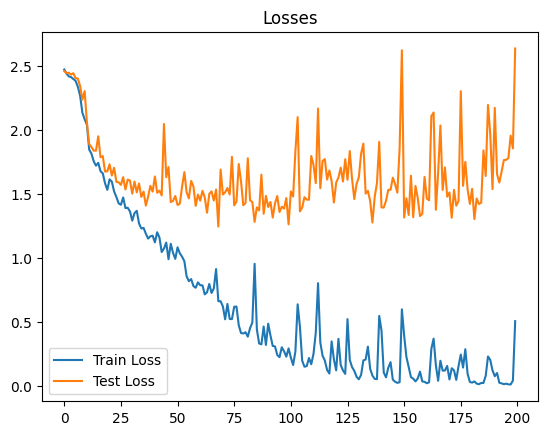

In [95]:
plt.plot(history['train_losses'], label='Train Loss')
plt.plot(history['test_losses'], label='Test Loss')
plt.title("Losses")
plt.legend()
plt.show()

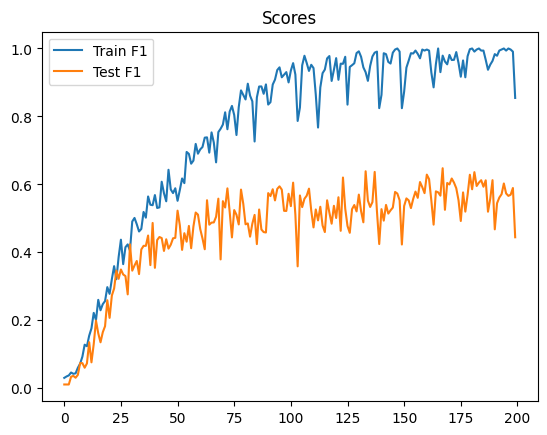

In [96]:
plt.plot(history['train_scores'], label="Train F1")
plt.plot(history['test_scores'], label="Test F1")
plt.title("Scores")
plt.legend()
plt.show()